<a href="https://colab.research.google.com/github/mind-render/MIDI_Classification/blob/main/train_midi_230609.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, files, labels, class_to_idx, transform):
        super(CustomImageDataset, self).__init__()
        self.files = files
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # file 경로
        file = self.files[idx]
        # PIL.Image로 이미지 로드
        img = Image.open(file).convert('RGB')
        # transform 적용
        img = self.transform(img)
        # label 생성
        lbl = self.class_to_idx[self.labels[idx]]
        # image, label return
        return img, lbl

In [ ]:
import torch
import torch.nn as nn
import zipfile
import glob
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image, UnidentifiedImageError,ImageFile
#from CustomImageDataset import CustomImageDataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU 사용
print(device)

cuda


In [ ]:
#from model import resnet
import torch.nn as nn
import torch.nn.functional as F

class IdentityPadding(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(IdentityPadding, self).__init__()
        # self.pooling = nn.MaxPool2d(1, stride=stride)
        # self.add_channels = out_channels - in_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        # self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        # out = F.pad(x, (0,0,0,0,0,self.add_channels))
        # out = self.pooling(out)
        out = self.conv(x)
        # out = self.bn(x)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(out_channels)

        if down_sample:
            self.down_sample = IdentityPadding(in_channels, out_channels, stride)
        else:
            self.down_sample = None

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        # out = self.bn2(out)

        if self.down_sample is not None:
            shortcut = self.down_sample(x)
        out += shortcut
        out = self.relu(out)
        return out


class Resnet(nn.Module):
    def __init__(self, num_layers, block, num_classes=10):
        super(Resnet, self).__init__()
        self.num_layers = num_layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)

        self.layer_2n = self.get_layers(block, in_channels=16, out_channels=16, stride=1)
        self.layer_4n = self.get_layers(block, in_channels=16, out_channels=32, stride=2)
        self.layer_6n = self.get_layers(block, in_channels=32, out_channels=64, stride=2)

        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.fc_out = nn.Linear(5184, num_classes)

        for m in self.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False
        
        layers_list = nn.ModuleList(
            [block(in_channels, out_channels, stride, down_sample)]
        )

        for _ in range(self.num_layers - 1):
            layers_list.append(block(out_channels, out_channels))

        return nn.Sequential(*layers_list)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer_2n(x)
        x = self.layer_4n(x)
        x = self.layer_6n(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        return x
    

def resnet(num_classes=10):
    block = ResidualBlock
    model = Resnet(5, block, num_classes)
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folders = glob.glob('/content/drive/MyDrive/data/*')
print(folders)

['/content/drive/MyDrive/data/bach_pianoroll_6000', '/content/drive/MyDrive/data/chopin_pianoroll_6000']


In [ ]:
# train: test ratio. 0.2로 설정시 test set의 비율은 20%로 설정
test_size = 0.2

# train / test 셋의 파일을 나눕니다.
train_images = []
test_images = []

for folder in folders:
    label = os.path.basename(folder)
    files = sorted(glob.glob(folder + '/*'))

    # 각 Label별 이미지 데이터셋 셔플
    random.seed(42)
    random.shuffle(files)

    idx = int(len(files) * test_size)
    train = files[:-idx]
    test = files[-idx:]

    train_images.extend(train)
    test_images.extend(test)

# train, test 전체 이미지 셔플
random.shuffle(train_images)
random.shuffle(test_images)

# Class to Index 생성. {'chopin': 1, 'Bach': 0}
class_to_idx = {os.path.basename(f):idx for idx, f in enumerate(folders)}

# Label 생성
train_labels = [f.split('/')[-2] for f in train_images]
test_labels = [f.split('/')[-2] for f in test_images]

print('==='*10)
print(f'train images: {len(train_images)}')
print(f'train labels: {len(train_labels)}')
print(f'test images: {len(test_images)}')
print(f'test labels: {len(test_labels)}')

train images: 9600
train labels: 9600
test images: 2400
test labels: 2400


In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [ ]:
train_dataset = CustomImageDataset(train_images, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, class_to_idx, test_transform)

In [ ]:
# train, test 데이터 로더 생성 => 모델 학습시 입력하는 데이터셋
train_loader = DataLoader(train_dataset, 
                          batch_size=64, 
                          shuffle=True,
                          num_workers=2
                         )

test_loader = DataLoader(test_dataset, 
                         batch_size=64, 
                         shuffle=True,
                         num_workers=2
                        )

In [ ]:

images, labels = next(iter(train_loader))


In [ ]:
images.shape

torch.Size([64, 3, 64, 64])

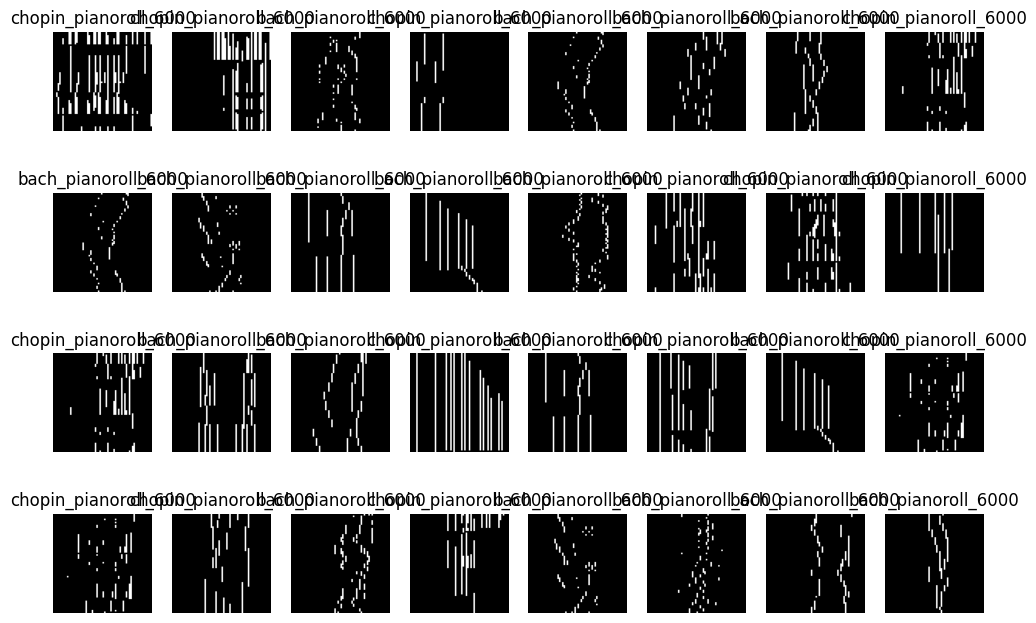

In [ ]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성되어 있습니다.
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [ ]:


model = resnet(num_classes=2)
model = model.to(device)
print(model)

In [ ]:
print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,betas=(0.9,0.999))

def train(epoch, global_steps):
    model.train()

    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        global_steps += 1
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        # print(outputs)
        # print(targets)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    acc = 100 * correct / total
    print(f'train epoch: {epoch} [{batch_idx+1} / {len(train_loader)}] ')
    print(f'loss: {train_loss / (batch_idx + 1)} | acc: {acc}')

    return global_steps

In [ ]:
def test(epoch, best_acc):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    print(f'test epoch: {epoch} [{batch_idx+1} / {len(test_loader)}] ')
    print(f'loss: {test_loss / (batch_idx + 1)} | acc: {acc}')

    if (acc > best_acc):
        best_acc = acc
    
    return best_acc

In [ ]:
best_acc = 0
epoch = 0
global_steps = 0

while True:
    epoch += 1
    global_steps = train(epoch, global_steps)
    best_acc = test(epoch, best_acc)
    print(f'best test acc: {best_acc}')

    # if global_steps > 64000:
    #     break
    if epoch>15:
        break

train epoch: 1 [150 / 150] 
loss: 0.7510203714172046 | acc: 66.79166666666667
test epoch: 1 [38 / 38] 
loss: 0.30080721448910863 | acc: 86.375
best test acc: 86.375
train epoch: 2 [150 / 150] 
loss: 0.3321373911698659 | acc: 85.46875
test epoch: 2 [38 / 38] 
loss: 0.23724492051099477 | acc: 89.54166666666667
best test acc: 89.54166666666667
train epoch: 3 [150 / 150] 
loss: 0.23937839547793072 | acc: 89.40625
test epoch: 3 [38 / 38] 
loss: 0.20344287529587746 | acc: 91.08333333333333
best test acc: 91.08333333333333
train epoch: 4 [150 / 150] 
loss: 0.20175974433620772 | acc: 91.59375
test epoch: 4 [38 / 38] 
loss: 0.19278077918447947 | acc: 91.5
best test acc: 91.5
train epoch: 5 [150 / 150] 
loss: 0.18836356868346532 | acc: 92.03125
test epoch: 5 [38 / 38] 
loss: 0.2150419454433416 | acc: 90.29166666666667
best test acc: 91.5
train epoch: 6 [150 / 150] 
loss: 0.1506142038355271 | acc: 93.8125
test epoch: 6 [38 / 38] 
loss: 0.1982922111882975 | acc: 91.375
best test acc: 91.5
train ep

In [ ]:
#저장
torch.save(model.state_dict(), '/content/drive/My Drive/model.pth')

In [ ]:
#data parallel 방식으로 학습한 모델 저장
torch.save(model.module.state_dict(), '/content/drive/My Drive/model_backup.pth')

AttributeError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
import sys
import numpy as np
import cv2

model.eval()
test_loss = 0
correct = 0
total = 0
inputs = cv2.imread('/content/drive/MyDrive/chopin_pianoroll/chopin11_76.png')
# print(inputs.shape)

cv2_imshow(inputs)
inputs = torch.Tensor(inputs.transpose(2,0,1))
inputs = inputs.unsqueeze(dim=0)

print(inputs.shape)
# with torch.no_grad():

#     outputs = model(inputs)
#     print(outputs)




NameError: ignored

In [ ]:
with torch.no_grad():
    inputs = inputs.to(device)
    
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    print(predicted)

tensor([1], device='cuda:0')
